# Import

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras import Sequential, Model, layers
import zipfile
import time
import warnings
import cv2

from sklearn.model_selection import train_test_split
from fastcore.all import dict2obj
from keras.callbacks import EarlyStopping

warnings.simplefilter(action='ignore')


# Load Data

In [39]:
# Unzip the training data
with zipfile.ZipFile("/content/drive/MyDrive/Facial-Keypoint-Detection/data/training.zip", "r") as zip_ref:
    zip_ref.extractall("/content/Facial-Keypoint-Detection/data")

# Unzip the test data
with zipfile.ZipFile("/content/drive/MyDrive/Facial-Keypoint-Detection/data/test.zip", "r") as zip_ref:
    zip_ref.extractall("/content/Facial-Keypoint-Detection/data")


In [40]:
# Read the training and test data into Pandas DataFrames
data = pd.read_csv('/content/Facial-Keypoint-Detection/data/training.csv')
submission_data = pd.read_csv('/content/Facial-Keypoint-Detection/data/test.csv')

# This map will come in handy at certain points
feature_names = data.columns[:-1]
features_map = {k: v for v,k in enumerate(feature_names)}

display(data.head(10))
print(f'Labeled data size: {len(data)}')
print(f'Submission data size: {len(submission_data)}')
print(f'Missing values in submission data (cumulative): {submission_data.isnull().sum().sum()}\n')
print(f'Missing values in data: \n{data.isnull().sum()}')

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
5,69.680748,39.968748,29.183551,37.563364,62.864299,40.169271,76.898243,41.171888,36.401047,39.367626,...,58.800000,64.869084,82.471178,31.990430,81.669084,49.308112,78.487626,49.432374,93.898766,167 169 170 167 156 145 106 68 52 24 20 15 21 ...
6,64.131866,34.290040,29.578953,33.138040,57.797154,35.154040,69.026577,34.290040,34.761664,33.714040,...,53.006174,55.781799,70.570953,33.898309,70.282953,45.127732,65.099597,45.415732,78.057020,109 109 125 141 145 139 120 81 45 34 31 35 36 ...
7,67.468893,39.413452,29.355961,39.621717,59.554951,40.454773,75.591612,40.038245,37.478214,40.454773,...,56.907961,66.843961,80.025786,30.189204,81.275184,48.100194,71.278602,48.516816,91.063922,178 177 178 179 179 179 181 185 188 184 192 20...
8,65.802880,34.755200,27.475840,36.185600,58.652160,37.329280,72.952960,35.899520,36.342400,37.043200,...,55.348480,65.516800,73.368320,31.194240,74.798080,49.213440,67.648000,49.499520,83.093120,164 158 118 76 66 69 59 53 43 31 35 41 45 55 6...
9,64.121231,36.740308,29.468923,38.390154,58.620923,37.840615,71.272000,37.290338,36.344615,39.490462,...,54.341538,65.771692,69.192615,32.769231,72.217846,49.270154,67.542769,49.545231,76.893538,226 227 225 224 221 220 215 210 210 208 206 18...


Labeled data size: 7049
Submission data size: 1783
Missing values in submission data (cumulative): 0

Missing values in data: 
left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y   



Around 4.8k samples present missing values for several keypoints. This is a significative amount of missing data, which amounts to roughly 70% of the dataset size. As of now however this will not be taken into account and I will just load the data dropping every row with even one missing landmark. Let's now look at some random images from the training data. In the hidden cell some conveniency functions are defined for data loading, image display and plot the loss of the Deep Learning models to be trained.

---



## Common functions used

In [41]:
# Conveniency functions
def load_data(csv_path, columns=None, dropna=True):
    """""
    load data and normalize the images
    - csv_path: path of csv file containing the data
    - columns: columns to load. If none load all
    - dropna: if True drop data rows with missing labels

    return:
    - X: 2-d numpy array (n_samples, img_size**2)
    - y: 2-d numpy array (n_samples, n_landmarks*2)
    """""

    test_set = csv_path.split('/')[-1] == 'test.csv'
    y = None

    df = pd.read_csv(csv_path)
    if columns != None:
        df = df[list(columns) + ['Image']]
    if dropna:
        df = df.dropna()
    if not test_set:
        y = df.drop(columns='Image').values

    X = df['Image'].apply(lambda x: np.fromstring(x, dtype='float', sep=' '))
    X = np.vstack(X) / 255.
    X = np.reshape(X, (len(X), 96, 96, 1))
    return X, y

def show_images(X, y, n_samples=5, seed=0):
    """""
    show random images and keypoints

    arguments:
    - X: images array
    - y: keypoints
    """""

    np.random.seed(seed)
    indices = np.random.choice(range(len(X)), size=n_samples, replace=False)
    indices = np.sort(indices)
    X_img = np.reshape(X, (len(X), 96, 96))[indices]
    y_img = y[indices]

    ncols = 5
    nrows = int(np.ceil(n_samples / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))
    for j, ix in enumerate(indices):
        if nrows > 1: ax = axs[j//ncols, j%ncols]
        else: ax = axs[j]
        ax.imshow(X_img[j], cmap='gray')
        ax.scatter(x=y_img[j,::2], y=y_img[j,1::2], marker='x', color='green', s=50)
        ax.set_title(f'Sample {ix}')
    fig.tight_layout()
    plt.show()

def plot_loss(history, model_name=None, rmse=True):
    """""
    set basic loss plot (MSE) of a fitted keras model

    arguments:
    - history: history of keras model fit
    - model_name: identifier string for the model
    - rmse: if True plot RMSE instead of MSE
    """""

    history = pd.DataFrame(history.history)
    if rmse: history = np.sqrt(history).round(4)
    sns.lineplot(history['loss'], label=f'Training loss: {model_name}', linestyle='--')
    sns.lineplot(history['val_loss'], label=f'Validation loss: {model_name}')
    plt.title('Training history'), plt.xlabel('epoch')
    plt.semilogy()

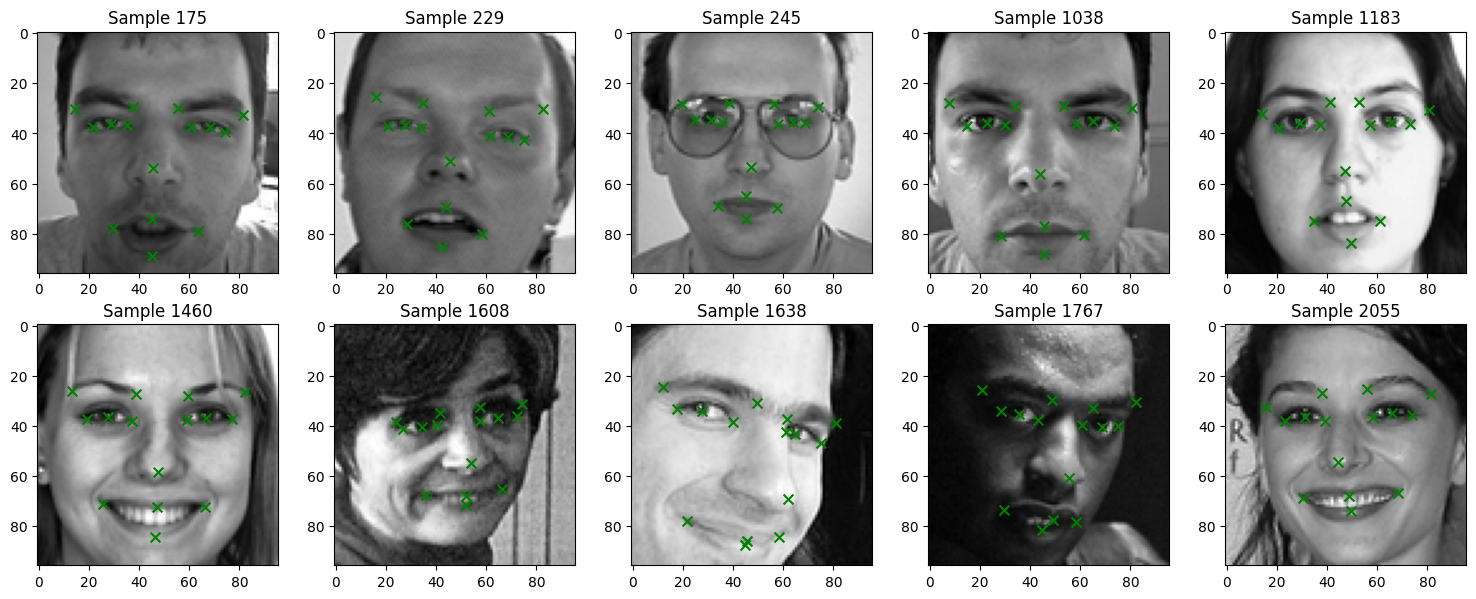

In [42]:
X, y = load_data('/content/Facial-Keypoint-Detection/data/training.csv')
show_images(X, y, n_samples=10)



---



# Base models

The hidden cell contains the definition of some test models. To get better equity in model evaluation data will be split on a 80/20 ratio and every model's performance will be evaluated through their score on the same validation set. The proposed architecture will also be trained with EarlyStopping monitoring validation loss with a patience of 10 epochs.

In [ ]:
# Models to test
def SimpleFC(input_shape):
    n_layers = 3
    n_units = [128 * 2**i for i in reversed(range(n_layers))]
    # Architecture
    inputs = layers.Input(input_shape, name='input')
    x = layers.Flatten(name='flatten')(inputs)
    x = layers.Dropout(0.5, name='dropout')(x)
    for j, units in enumerate(n_units):
        x = layers.Dense(units, activation='relu', name=f'dense_{j+1}')(x)
    outputs = layers.Dense(30, name='output')(x)
    # Define model and compile
    model = Model(inputs, outputs, name='SimpleFC')
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

def SimpleCNN(input_shape):
    n_layers = 3
    n_filters = [32 * 2**i for i in range(n_layers)]
    # Architecture
    inputs = layers.Input(input_shape, name='input')
    x = inputs
    for j, filters in enumerate(n_filters):
        x = layers.Conv2D(filters, kernel_size=(3,3), activation='relu', name=f'conv_{j+1}')(x)
        x = layers.MaxPooling2D(name=f'pooling_{j+1}')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(512, activation='relu', name='dense_1')(x)
    x = layers.Dense(512, activation='relu', name='dense_2')(x)
    outputs = layers.Dense(30, name='output')(x)
    # Define model and compile
    model = Model(inputs, outputs, name='SimpleCNN')
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

## Define parameters model setting.

In [ ]:
# Training parameters
pms = dict2obj({
    'test_size': 0.2,
    'random_state': 0,
    'batch_size': 32,
    'epochs': 300,
})
# Early stopping parameters
stop_pms = {
    'monitor': 'val_loss',
    'patience': 10,
    'restore_best_weights': True,
}

## Fiting Base Models

In [ ]:
### Fitting
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                 test_size=pms.test_size,
                                                 shuffle=True,
                                                 random_state=pms.random_state)

models = {'SimpleFC':  SimpleFC(X.shape[1:]),
          'SimpleCNN': SimpleCNN(X.shape[1:])}

histories = dict()
for name, model in models.items():
    histories[name] = model.fit(X_train, y_train,
                                validation_data=(X_val, y_val),
                                shuffle=True,
                                batch_size=pms.batch_size,
                                epochs=pms.epochs,
                                callbacks=EarlyStopping(**stop_pms),
                                verbose=0,
                               )

Model: "SimpleFC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dropout (Dropout)           (None, 9216)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               4719104   
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 output (Dense)              (None, 30)                387

Validation RMSE of SimpleFC = 4.487247467041016
Validation RMSE of SimpleCNN = 2.5206971168518066


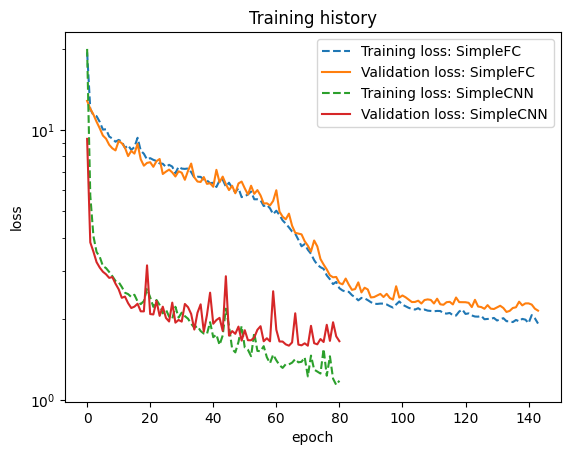

In [ ]:
for name in histories.keys():
    plot_loss(histories[name], model_name=name)
    print(f'Validation RMSE of {name} = {min(histories[name].history["val_loss"])}')
plt.show()

The convolutional network outperforms the fully-connected architecture as one might expect, obtaining a smaller loss in fewer training epochs. However, there are issues with both architectures' training, as evidenced by the validation loss's severe oscillations. Although the training curve seems to be smoothed out by increasing the batch size, the loss is negatively impacted by this modification. This implies that the reason for these oscillations could be that certain batches of validation data are particularly "difficult" to train on. Increasing the training data's size to increase its variance could be one way to address this situation.


---



# Data Augmentation

Applying geometric change (turning, rotating, shifting, etc.) and color adjustments (brightness, saturation, contrast, etc.) to the training data is known as data augmentation in computer vision. Although this method just works with photos to solve the majority of common landmark identification tasks, the data augmentation process becomes more complex because the same geometric transformations that are given to images also need to be applied to the landmarks. I searched for strong substitutes for Keras ImageDataGenerator that would also work for landmark detection, but I was unable to locate any. For this reason, handwritten customized techniques for data augmentation will be used.

In [ ]:
class CustomGenerator:

    def __init__(self, flip_indices=None, seed=0):
        if flip_indices is None:
            flip_indices = [(0,2), (1,3),
                            (4,8), (5,9), (6,10), (7,11),
                            (12,16), (13,17), (14,18), (15,19),
                            (22,24), (23,25)]
        self.flip_indices = flip_indices
        self.seed = seed


    def hflip(self, X, y, flip_indices):
        """""
        flip X, y horizontally (flip_indices is needed to swap landmarks)
        """""
        X_hflip = X[:,:,::-1,:]
        y_hflip = y.copy()
        y_hflip[:,::2] = 96 - y_hflip[:,::2]
        for idx1, idx2 in flip_indices:
            y_hflip[:, [idx1, idx2]] = y_hflip[:, [idx2, idx1]]
        return X_hflip, y_hflip


    def adjust_brightness(self, X, y=None, brightness=1):
        """""
        adjust X brightness according to brightness multiplier
        """""
        X_bright = np.clip(X * brightness, X.min(), X.max())
        return X_bright, y


    def adjust_shift(self, X, y, shift=[0,0]):
        """""
        shift X, y according to shift=[shift_x, shift_y]
        """""
        ox, oy = shift
        y_shift = y.copy()
        y_shift[:,::2] += ox
        y_shift[:,1::2] += oy
        y_shift = np.clip(y_shift, 0, 96)

        X_shift = np.pad(X, mode='constant', pad_width=((0,0),
                                                        (abs(oy), abs(oy)),
                                                        (abs(ox), abs(ox)),
                                                        (0,0)))
        if ox >= 0 and oy >= 0:
            X_shift = X_shift[:,:96,:96,:]
        elif ox >= 0 and oy <= 0:
            X_shift = X_shift[:,2*abs(oy):,:96,:]
        elif ox <= 0 and oy >= 0:
            X_shift = X_shift[:,:96,2*abs(ox):,:]
        elif ox <= 0 and oy <= 0:
            X_shift = X_shift[:,2*abs(oy):,2*abs(ox):,:]
        return X_shift, y_shift


    def make_batches(self, X, y, batch_size):
        """""
        split X, y into batches of size batch_size
        """""
        num_batches = len(X) // batch_size + 1
        X_batches = [X[i * batch_size: (i + 1) * batch_size] for i in range(num_batches)]
        y_batches = [y[i * batch_size: (i + 1) * batch_size] for i in range(num_batches)]
        return X_batches, y_batches


    def generate(self, X, y, batch_size=32, max_shift=10, max_bright=0.5, shuffle=True):
        """""
        generate new images from X, y
        """""
        np.random.seed(self.seed)
        X_batches, y_batches = self.make_batches(X, y, batch_size)

        X_new, y_new = X.copy(), y.copy()
        for X_batch, y_batch in zip(X_batches, y_batches):
            # batch transformation parameters
            shift = np.random.randint(-max_shift, max_shift, size=2)
            brightness = np.random.uniform(1-max_bright, max_bright)
            # transformation
            X_hflip, y_hflip = self.hflip(X_batch, y_batch, self.flip_indices)
            X_shift, y_shift = self.adjust_shift(X_batch, y_batch, shift=shift)
            X_bright, y_bright = self.adjust_brightness(X_batch, y_batch, brightness=brightness)
            # stack toghether
            X_gen = np.concatenate([X_hflip, X_shift, X_bright])
            y_gen = np.concatenate([y_hflip, y_shift, y_bright])
            X_new = np.concatenate([X_new, X_gen])
            y_new = np.concatenate([y_new, y_gen])

        if shuffle:
            permutation = np.random.permutation(len(X_new))
            X_new = X_new[permutation,:,:,:]
            y_new = y_new[permutation,:]
        return X_new, y_new

Model: "SimpleCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 pooling_1 (MaxPooling2D)    (None, 47, 47, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 45, 45, 64)        18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 22, 22, 64)        0         
                                                                 
 conv_3 (Conv2D)             (None, 20, 20, 128)       73856     
                                                                 
 pooling_3 (MaxPooling2D)    (None, 10, 10, 128)       0 

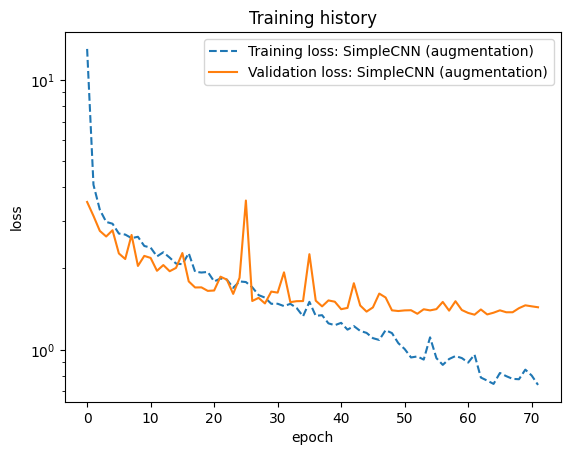

Validation RMSE = 2.0608


In [ ]:
generator = CustomGenerator()
X_res, y_res = generator.generate(X_train, y_train)

model_1 = SimpleCNN(X_res.shape[1:])
history = model_1.fit(X_res, y_res,
                      validation_data=(X_val, y_val),
                      batch_size=pms.batch_size,
                      epochs=pms.epochs,
                      callbacks=EarlyStopping(**stop_pms),
                      verbose=2)

plot_loss(history, model_name='SimpleCNN (augmentation)')
plt.show()

final_loss = round(pd.DataFrame(history.history)['val_loss'].iloc[-1], 4)
print(f'Validation RMSE = {final_loss}')

The validation loss curve looks somewhat smoother than it did previously, as predicted (the y-axis scale is slightly different). Furthermore, a rise in the validation score is already apparent. But keep in mind that while the total number of samples in the training data is substantially higher, only roughly 2,000 samples are taken into consideration in this pipeline. An illustration of how to handle this problem is provided in the following section.


---



# Ensemble of specialists model

1.   Create custom settings for each specialist, specifying the landmarks to predict and the respective flip indices (needed for the horizontal flip function)
2.   Initialize the list of specialists and start a loop to train each one separately
3. Load the data subset from the columns to predict
Apply data augmentation to the subset
4. Fit the specialist model using model_1 as source
5. Store the submodel and other relevant info as a dictionary in the specialists list


In [ ]:
class Specialist:

    def __init__(self, source_model, spec_settings):
        """""
        arguments:
        - source_model: pretrained model
        - settings: list of dictionaries indicating model_name, columns to load from data
        """""
        self.source_model = source_model
        self.settings = spec_settings
        self.fitted_models = None

    def create_specialist(self, out_shape):
        """""
        create specialist model with transfer learning

        arguments:
        - out_shape: shape of specialist output layer

        return:
        - model: single specialist model
        """""
        model = Sequential()
        for layer in self.source_model.layers[:-1]:
            model.add(layer)
            layer.trainable = False
        model.add(layers.Dense(out_shape, name='output'))
        model.compile(optimizer='adam', loss='mse')
        return model


    def fit(self, csv_path, pms, stop_pms):
        """""
        create specialist model with transfer learning

        arguments:
        - csv_path: training data path
        """""
        self.fitted_models = []
        for settings in self.settings:
            X, y = load_data(csv_path, columns=settings['cols'])
            generator = CustomGenerator(flip_indices=settings['x_flip'])
            X_new, y_new = generator.generate(X, y, shuffle=True)

            print(f'Fitting {settings["model_name"]} specialist...')
            t0 = time.time()
            sub_model = self.create_specialist(out_shape=len(settings['cols']))
            history = sub_model.fit(X_new, y_new,
                                    validation_split=pms.test_size,
                                    batch_size=pms.batch_size,
                                    epochs=pms.epochs,
                                    callbacks=EarlyStopping(**stop_pms),
                                    verbose=0)
            specialist = {'model_name': settings['model_name'],
                          'cols': settings['cols'],
                          'model': sub_model,
                          'history': history}
            print(f'Completed in {round(time.time() - t0)}s')
            self.fitted_models.append(specialist)


    def predict(self, X):
        """""
        make predictions

        arguments:
        - X: test images

        return:
        - y_pred: predictions array (n_samples, 30)
        """""
        y_pred = pd.DataFrame()
        for specialist in self.fitted_models:
            sub_model = specialist['model']
            cols = list(specialist['cols'])
            y_pred[cols] = sub_model.predict(X, verbose=0)
        return y_pred.values

In [ ]:
specialists_settings = [
    dict(model_name='eye_center',
         cols=('left_eye_center_x', 'left_eye_center_y',
               'right_eye_center_x', 'right_eye_center_y'),
         x_flip=[(0,2), (1,3)]),
    dict(model_name='eye_corner',
         cols=('left_eye_inner_corner_x', 'left_eye_inner_corner_y',
               'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
               'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
               'right_eye_outer_corner_x', 'right_eye_outer_corner_y'),
         x_flip=[(0,4), (1,5), (2,6), (3,7)]),
    dict(model_name='eyebrow_end',
         cols=('left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
               'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
               'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
               'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y'),
         x_flip=[(0,4), (1,5), (2,6), (3,7)]),
    dict(model_name='nose_tip',
         cols=('nose_tip_x', 'nose_tip_y'),
         x_flip=[(0,0), (1,1)]),
    dict(model_name='mouth',
         cols=('mouth_left_corner_x', 'mouth_left_corner_y',
               'mouth_right_corner_x', 'mouth_right_corner_y',
               'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
               'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'),
         x_flip=[(0,2), (1,3), (4,4), (5,5), (6,6), (7,7)]),
]

In [ ]:
# Model fit
model_2 = Specialist(source_model=model_1, spec_settings=specialists_settings)
model_2.fit(csv_path='/content/Facial-Keypoint-Detection/data/training.csv', pms=pms, stop_pms=stop_pms)

Fitting eye_center specialist...
Completed in 147s
Fitting eye_corner specialist...
Completed in 137s
Fitting eyebrow_end specialist...
Completed in 43s
Fitting nose_tip specialist...
Completed in 213s
Fitting mouth specialist...
Completed in 52s


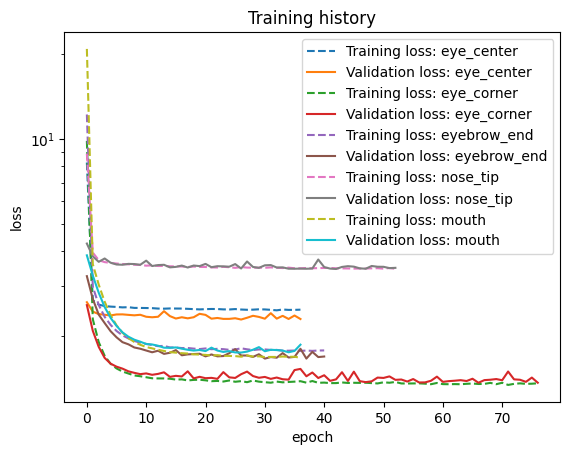

Final validation RMSE = 1.407


In [ ]:
from sklearn.metrics import mean_squared_error
# Training history
for specialist in model_2.fitted_models:
    plot_loss(specialist['history'], model_name=specialist['model_name'])
plt.show()

# Get model score
y_predval = model_2.predict(X_val)
y_predval = np.clip(y_predval, 0, 96)
print(f'Final validation RMSE = {round(np.sqrt(mean_squared_error(y_val, y_predval)), 4)}')

With the new model validation loss have decreased by an additional 0.6. The history plot allows to formulate some in-depth observations:

The learning process shows heavy oscillations for mouth and eye_center, implying difficulty in learning these features Despite possibly having the smoothest loss curve, nose_tip have a remarkably higher loss than the other submodels


---



# Error Analysis

In [ ]:
X_err = pd.DataFrame((y_val - y_predval)**2, columns=feature_names)
features_rmse = np.sqrt(1 / len(X_err) * X_err.sum())
features_rmse = features_rmse.round(4).sort_values(ascending=False)

print('Validation RMSE by landmark \n')
features_rmse

Validation RMSE by landmark 



nose_tip_y                   3.3898
mouth_center_bottom_lip_y    1.9889
left_eyebrow_outer_end_y     1.6887
nose_tip_x                   1.6260
left_eyebrow_outer_end_x     1.6180
right_eyebrow_outer_end_y    1.5902
mouth_center_top_lip_y       1.5536
mouth_left_corner_x          1.5496
left_eyebrow_inner_end_x     1.4242
mouth_right_corner_y         1.3927
mouth_right_corner_x         1.3221
right_eyebrow_outer_end_x    1.3212
right_eyebrow_inner_end_x    1.3077
mouth_left_corner_y          1.3012
left_eye_outer_corner_x      1.2903
left_eyebrow_inner_end_y     1.2709
right_eyebrow_inner_end_y    1.2556
mouth_center_bottom_lip_x    1.1882
mouth_center_top_lip_x       1.1701
left_eye_center_x            1.1448
right_eye_center_x           1.0967
left_eye_inner_corner_x      1.0600
right_eye_center_y           1.0439
left_eye_center_y            1.0133
right_eye_outer_corner_x     0.9970
right_eye_inner_corner_x     0.8944
left_eye_outer_corner_y      0.8408
right_eye_outer_corner_y    

In confirmation of what previously observed, the largest error by far is recorded for the detection of nose tip landmarks. Mouth features also show a significantly high prediction error (with an exception for mouth_center_bottom_lip_x, mouth_center_top_lip_x). Landmarks in the top part of the face seem to be predicted quite more accurately.

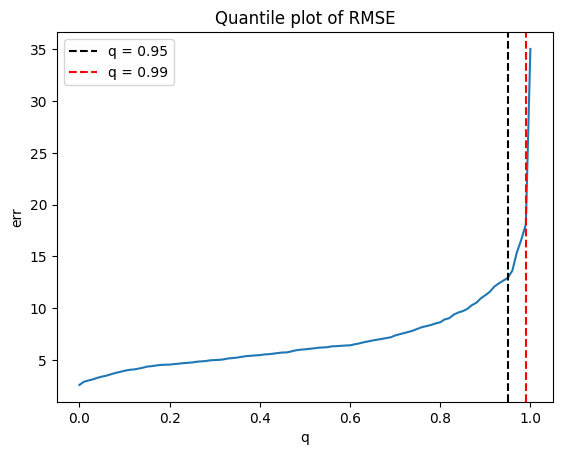

In [43]:
# MSE quantile plot
sns.lineplot(data=q_err, x='q', y='err')
plt.axvline(x=0.95, color='k', linestyle='--', label='q = 0.95')
plt.axvline(x=0.99, color='r', linestyle='--', label='q = 0.99')
plt.title('Quantile plot of RMSE'), plt.legend()
plt.show()

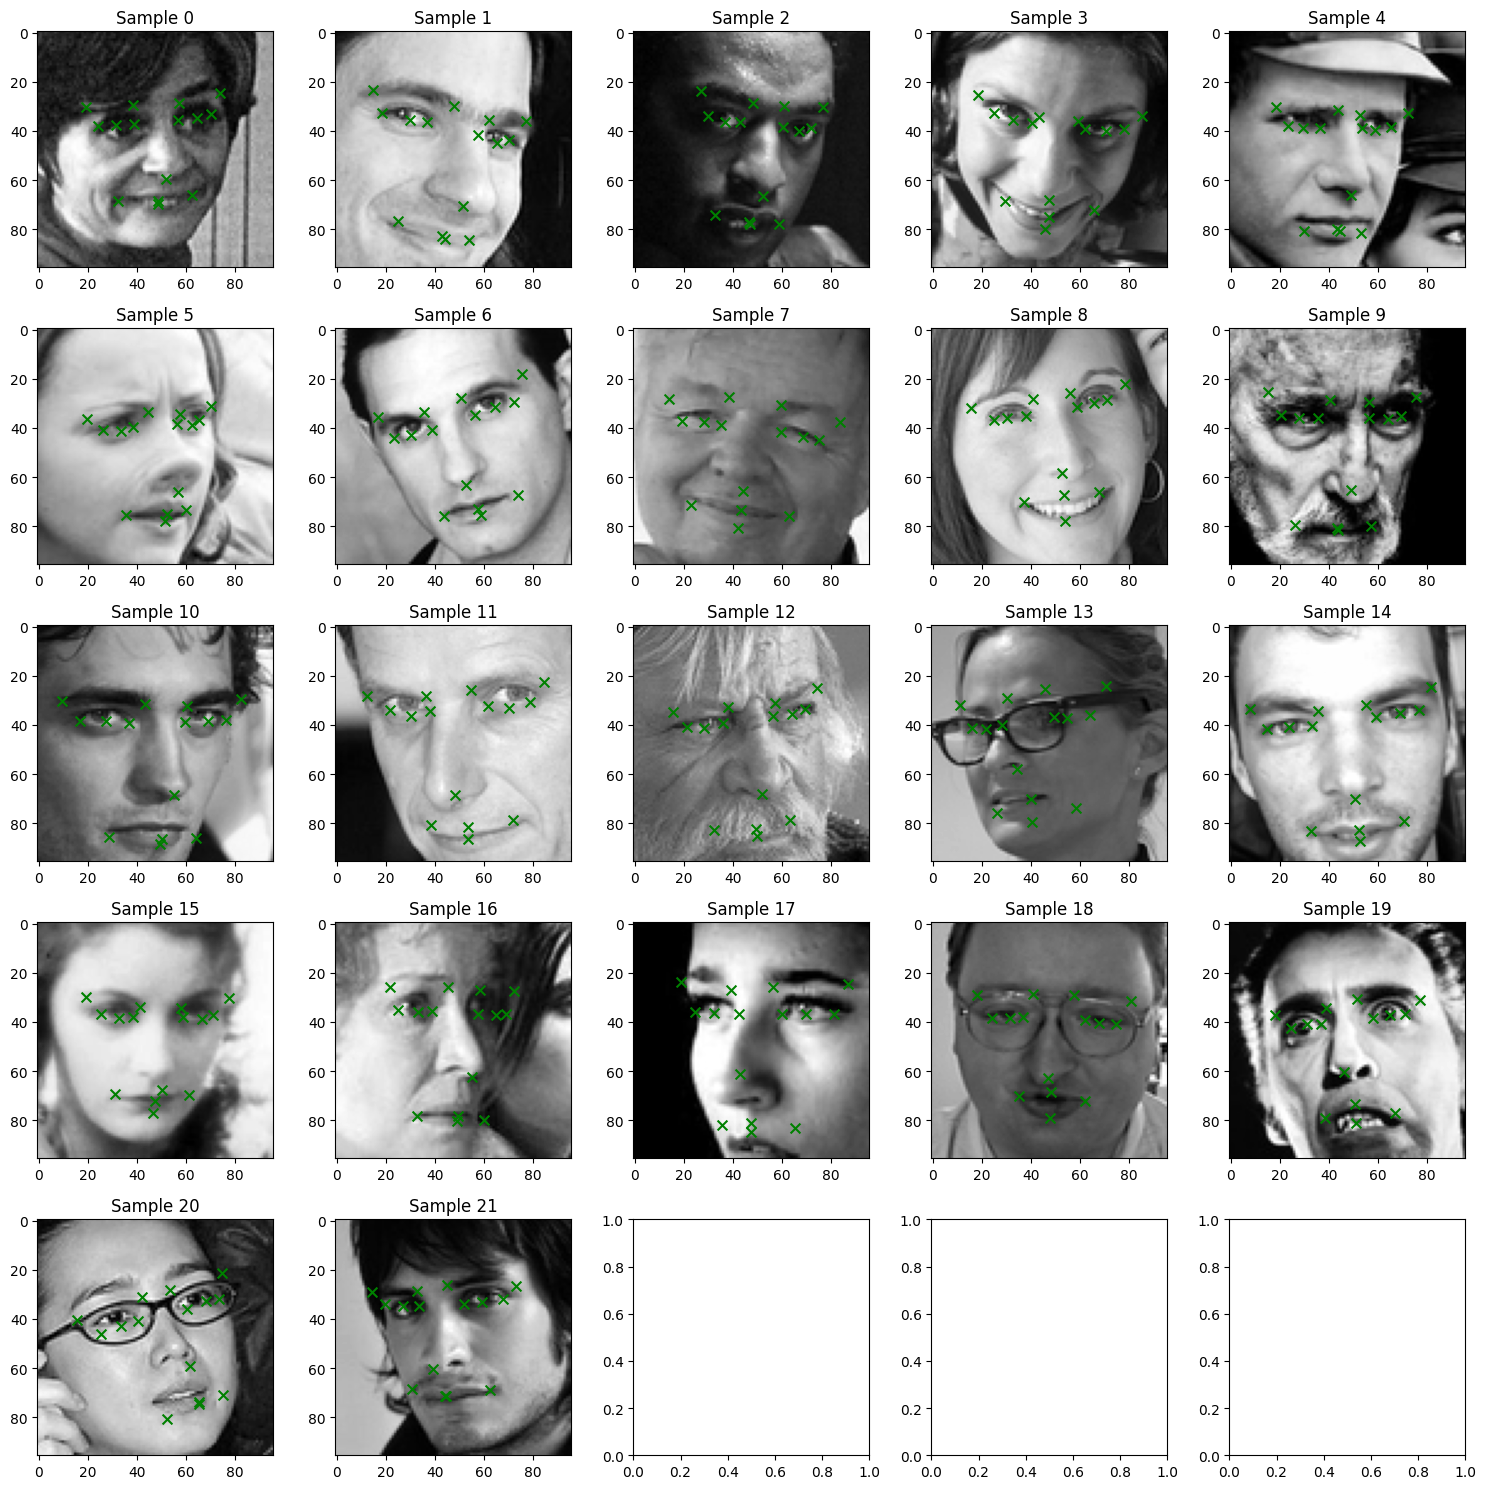

Number of samples over 95 error quantile = 22
Number of samples over 99 error quantile = 5


In [44]:
# Compute MSE matrix X_err and its quantiles
X_rmse = np.sqrt(X_err.sum(axis=1))
q_err = pd.DataFrame()
q_err['q'] = np.linspace(0, 1, 101)
q_err['err'] = [X_rmse.quantile(x) for x in q_err['q']]

# Show high-error predictions
X_err95 = X_err.loc[X_rmse > q_err["err"].iloc[-6]]
X_err99 = X_err.loc[X_rmse > q_err["err"].iloc[-2]]
show_images(X_val[X_err95.index], y_predval[X_err95.index], n_samples=len(X_err95))
print(f'Number of samples over 95 error quantile = {len(X_err95)}')
print(f'Number of samples over 99 error quantile = {len(X_err99)}')

The RMSE-quantile plot shows that the RMSE is lower than 15 for 95% of the predicted samples but spikes up for the remaining 5%, even reaching the value of 38.



In [ ]:
# Compute global predictions
X_sub, _ = load_data('/content/Facial-Keypoint-Detection/data/test.csv')
y_pred = model_2.predict(X_sub)
y_pred = np.clip(y_pred, 0, 96)

# Create features map
table = pd.read_csv('/content/drive/MyDrive/Facial-Keypoint-Detection/data/IdLookupTable.csv')
y_sub = pd.read_csv('/content/drive/MyDrive/Facial-Keypoint-Detection/data/SampleSubmission.csv')
feature_names = table['FeatureName'].unique()
features_map = {k: v for v,k in enumerate(feature_names)}
y_sub['Location'] = [y_pred[x-1, features_map[y]] for x, y in zip(table['ImageId'], table['FeatureName'])]
y_sub.to_csv('submission.csv', index=False)

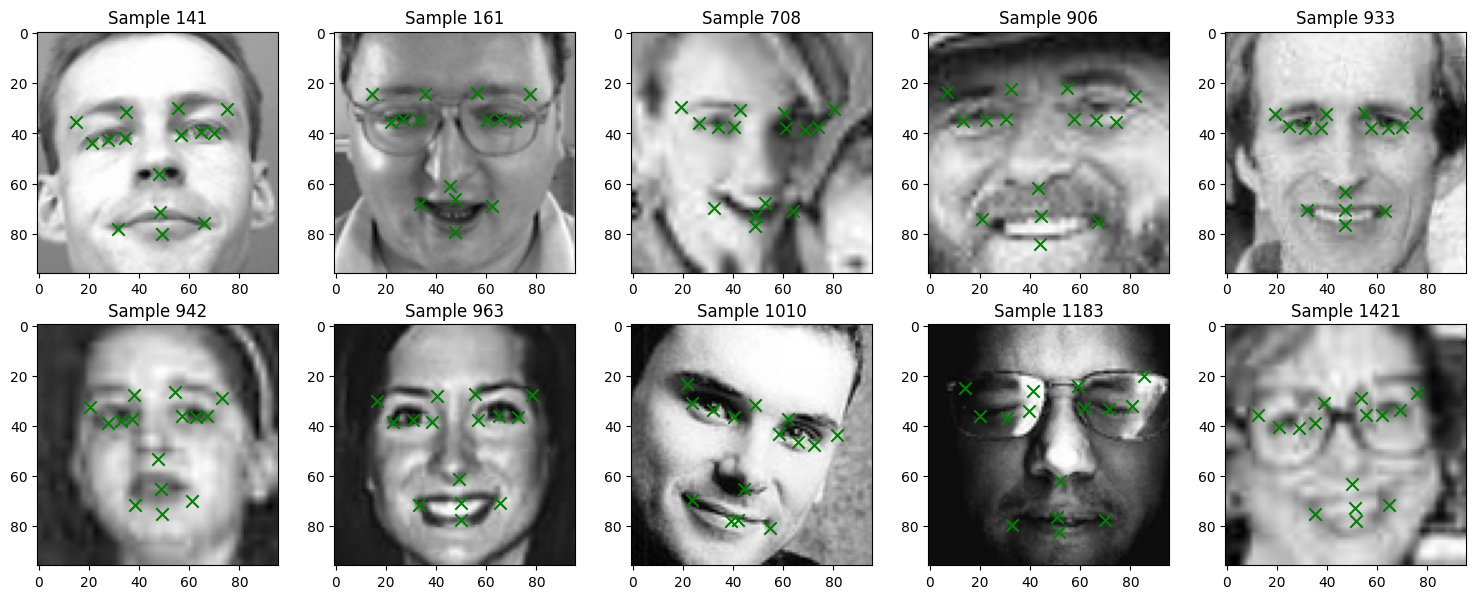

In [ ]:
# Show some random predictions
show_images(X_sub, y_pred, n_samples=10)